In [1]:
import torch
import deeplay as dl
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader



In [2]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(folder) if f.endswith('.png')]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.folder, self.image_files[idx])
        image = Image.open(img_path)
        label = int(self.image_files[idx].split('_')[0])
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNISTDataset('train', transform=transform)
test_dataset = MNISTDataset('test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
conv_base = dl.ConvolutionalNeuralNetwork(
    in_channels=1, hidden_channels=[16, 16, 32], out_channels=32,
)
conv_base.blocks[2].pool.configure(torch.nn.MaxPool2d, kernel_size=2)

connector = dl.Layer(torch.nn.AdaptiveAvgPool2d, output_size=1)

dense_top = dl.MultiLayerPerceptron(
    in_features=32,
    hidden_features=[64],
    out_features=10,
    out_activation=torch.nn.LogSoftmax(dim=1)
)

cnn = dl.Sequential(conv_base, connector, dense_top)

In [6]:
print(cnn)

Sequential(
  (0): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (1): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (2): Conv2dBlock(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (3): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[Identity]()
      )
    )
  )
  (1): Layer[AdaptiveAvgPool2d](output_size=1)
  (2): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Layer[Linear](in_features=32, out_features=64, bias=T

In [7]:
class MNISTClassifier(dl.Classifier):
    def __init__(self, model, optimizer):
        super().__init__(model=model, optimizer=optimizer)
        self.loss_fn = torch.nn.NLLLoss()  # Negative Log Likelihood Loss
        self.train_loss_history = []  # Stores loss per epoch
        self.train_acc_history = []   # Stores accuracy per epoch
        self.current_epoch_train_loss = []  # Temporary batch losses
        self.current_epoch_train_acc = []   # Temporary batch accuracies
        
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()
        
        # Store batch metrics
        self.current_epoch_train_loss.append(loss.item())
        self.current_epoch_train_acc.append(acc.item())
        
        return loss
        
    def on_train_epoch_end(self):
        # Calculate epoch averages
        epoch_loss = sum(self.current_epoch_train_loss) / len(self.current_epoch_train_loss)
        epoch_acc = sum(self.current_epoch_train_acc) / len(self.current_epoch_train_acc)
        
        self.train_loss_history.append(epoch_loss)
        self.train_acc_history.append(epoch_acc)
        
        self.current_epoch_train_loss = []
        self.current_epoch_train_acc = []
        
        print(f"Epoch {len(self.train_loss_history)} - Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2%}")

In [8]:
mnist_classifier = MNISTClassifier(
    model=cnn,
    optimizer=dl.RMSprop(lr=0.001)
).create()

In [9]:
print(mnist_classifier)

MNISTClassifier(
  (loss): CrossEntropyLoss()
  (optimizer): RMSprop[RMSprop](lr=0.001)
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): Sequential(
    (0): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (layer): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (3): Conv2dBlock(
          (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [10]:
trainer = dl.Trainer(max_epochs=5, accelerator="auto")

print("Starting training...")
trainer.fit(mnist_classifier, train_loader)

print("\nTraining History:")
for epoch, (loss, acc) in enumerate(zip(mnist_classifier.train_loss_history, mnist_classifier.train_acc_history)):
    print(f"Epoch {epoch + 1}/5")
    print(f"Train Loss: {loss:.4f} | Train Acc: {acc:.2%}")
    print("----------------------")

C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------

Starting training...
Epoch 4: 100%|██████████| 1875/1875 [00:57<00:00, 32.53it/s, v_num=13]

Training History:
Epoch 1/5
Train Loss: 0.9913 | Train Acc: 63.66%
----------------------
Epoch 2/5
Train Loss: 0.2666 | Train Acc: 91.66%
----------------------
Epoch 3/5
Train Loss: 0.1587 | Train Acc: 95.03%
----------------------
Epoch 4/5
Train Loss: 0.1162 | Train Acc: 96.37%
----------------------
Epoch 5/5
Train Loss: 0.0923 | Train Acc: 97.15%
----------------------


In [11]:
print("\nTraining History:")
for epoch in range(len(mnist_classifier.train_loss_history)):
    print(f"Epoch {epoch + 1}/{len(mnist_classifier.train_loss_history)}")
    print(f"Train Loss: {mnist_classifier.train_loss_history[epoch]:.4f} | Train Acc: {mnist_classifier.train_acc_history[epoch]:.2%}")
    print("----------------------")


Training History:
Epoch 1/5
Train Loss: 0.9913 | Train Acc: 63.66%
----------------------
Epoch 2/5
Train Loss: 0.2666 | Train Acc: 91.66%
----------------------
Epoch 3/5
Train Loss: 0.1587 | Train Acc: 95.03%
----------------------
Epoch 4/5
Train Loss: 0.1162 | Train Acc: 96.37%
----------------------
Epoch 5/5
Train Loss: 0.0923 | Train Acc: 97.15%
----------------------



【Final Test Results】
Overall Accuracy: 97.85% (9785/10000)

Class-Wise Accuracy:
Digit 0: 98.67% (967/980)
Digit 1: 99.12% (1125/1135)
Digit 2: 97.48% (1006/1032)
Digit 3: 97.03% (980/1010)
Digit 4: 97.86% (961/982)
Digit 5: 98.21% (876/892)
Digit 6: 98.43% (943/958)
Digit 7: 97.18% (999/1028)
Digit 8: 98.05% (955/974)
Digit 9: 96.43% (973/1009)


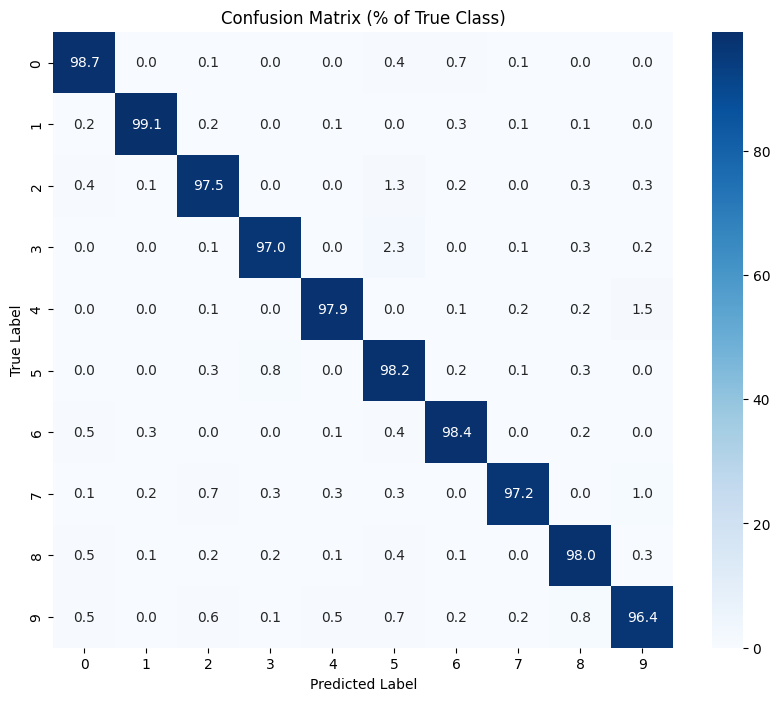

In [12]:
# TESTING PHASE - Run this ONLY AFTER training is complete

def test_model(model, test_loader):
    """Complete test evaluation with:
    - Overall accuracy
    - Class-wise acuracy
    - Confusion matrix (percentage)
    """
    model.eval()
    correct, total = 0, 0
    class_correct = [0] * 10
    class_total = [0] * 10
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            for label in range(10):
                class_mask = (labels == label)
                class_correct[label] += (preds[class_mask] == label).sum().item()
                class_total[label] += class_mask.sum().item()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
     
    print(f"\n【Final Test Results】")
    print(f"Overall Accuracy: {correct/total:.2%} ({correct}/{total})")
    
   
    print("\nClass-Wise Accuracy:")
    for i in range(10):
        if class_total[i] > 0:
            print(f"Digit {i}: {class_correct[i]/class_total[i]:.2%} ({class_correct[i]}/{class_total[i]})")
    
    cm = confusion_matrix(all_labels, all_preds, normalize='true') * 100
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (% of True Class)')
    plt.show()

test_model(mnist_classifier.model, DataLoader(test_dataset, batch_size=32))

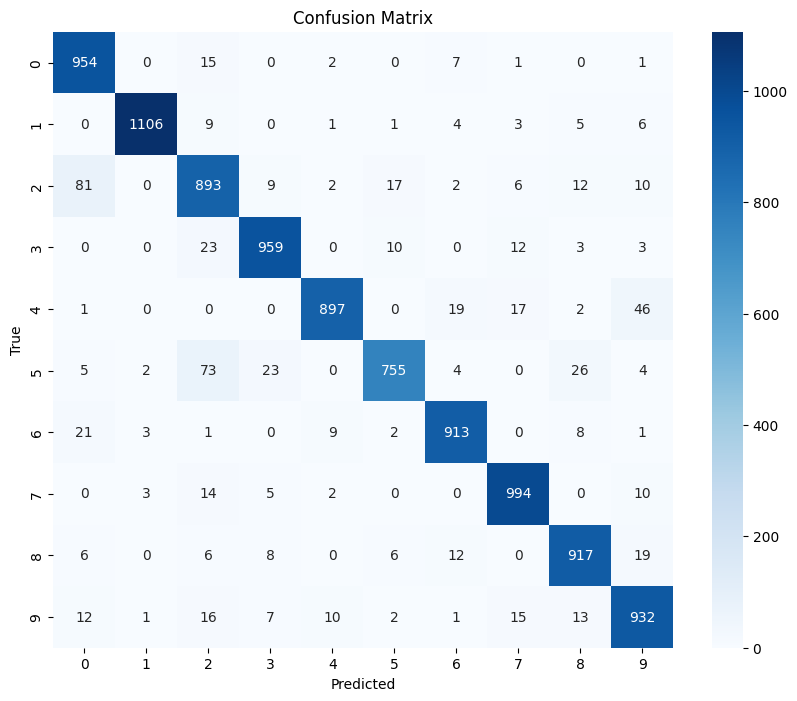

In [55]:
def plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for x, y in dataloader:
            y_hat = model(x)
            preds = torch.argmax(y_hat, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
plot_confusion_matrix(mnist_classifier.model, test_loader, class_names=[str(i) for i in range(10)])

In [13]:
import torch
from collections import defaultdict
from PIL import Image
import numpy as np

class_samples = {i: [] for i in range(10)}
for img, label in test_dataset:
    if len(class_samples[label]) < 2:
        class_samples[label].append((img, label))
    if all(len(v) == 2 for v in class_samples.values()):
        break

all_results = []

target_layer = mnist_classifier.model[0].blocks[2].layer  

for label in range(10):
    for img_idx in range(2):
        image_tensor, true_label = class_samples[label][img_idx]
        image_hr = Image.fromarray((image_tensor.squeeze().numpy() * 255).astype('uint8'))
        
        hookdata = {}
        
        def fwd_hook(layer, input, output):
            hookdata["activations"] = output.detach().clone()
        
        def bwd_hook(layer, grad_input, grad_output):
            hookdata["gradients"] = grad_output[0].detach().clone()
        
        handle_fwd = target_layer.register_forward_hook(fwd_hook)
        handle_bwd = target_layer.register_full_backward_hook(bwd_hook)
        
        try:
            pred = mnist_classifier.model(image_tensor.unsqueeze(0))
            pred_class = pred.argmax().item()
            
            mnist_classifier.model.zero_grad()
            pred[0, pred_class].backward()
            
            all_results.append({
                'image': image_hr,
                'true_label': true_label,
                'pred_class': pred_class,
                'activations': hookdata["activations"][0],
                'gradients': hookdata["gradients"][0]
            })
            
        except Exception as e:
            print(f"Error processing class {label} sample {img_idx}: {e}")
        finally:
            handle_fwd.remove()
            handle_bwd.remove()

In [14]:
from torch.nn.functional import relu

for result in all_results:
    pooled_gradients = result['gradients'].mean(dim=[1, 2], keepdim=True)
    heatmap = (pooled_gradients * result['activations']).sum(0)
    result['heatmap'] = relu(heatmap).detach().cpu().numpy()


Training Set Class Distribution:
Digit 0:  5923 images
Digit 1:  6742 images
Digit 2:  5958 images
Digit 3:  6131 images
Digit 4:  5842 images
Digit 5:  5421 images
Digit 6:  5918 images
Digit 7:  6265 images
Digit 8:  5851 images
Digit 9:  5949 images


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Test Set Class Distribution:
Digit 0:   980 images
Digit 1:  1135 images
Digit 2:  1032 images
Digit 3:  1010 images
Digit 4:   982 images
Digit 5:   892 images
Digit 6:   958 images
Digit 7:  1028 images
Digit 8:   974 images
Digit 9:  1009 images


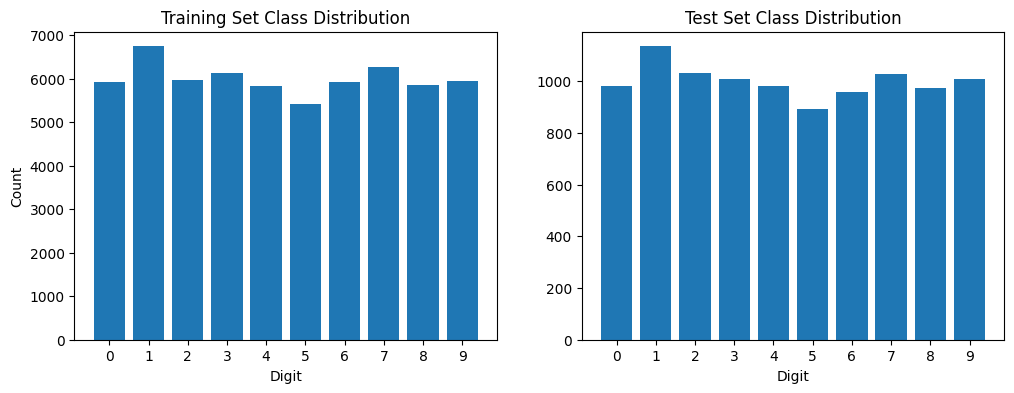

In [16]:
def count_classes(dataset, name="Dataset"):
    counts = {str(i): 0 for i in range(10)}
    for _, label in dataset:
        counts[str(label)] += 1
    print(f"\n{name} Class Distribution:")
    for digit, count in counts.items():
        print(f"Digit {digit}: {count:5d} images")
    return counts

train_counts = count_classes(train_dataset, "Training Set")

test_counts = count_classes(test_dataset, "Test Set")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(train_counts.keys(), train_counts.values())
plt.title("Training Set Class Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.bar(test_counts.keys(), test_counts.values())
plt.title("Test Set Class Distribution")
plt.xlabel("Digit")
plt.show()

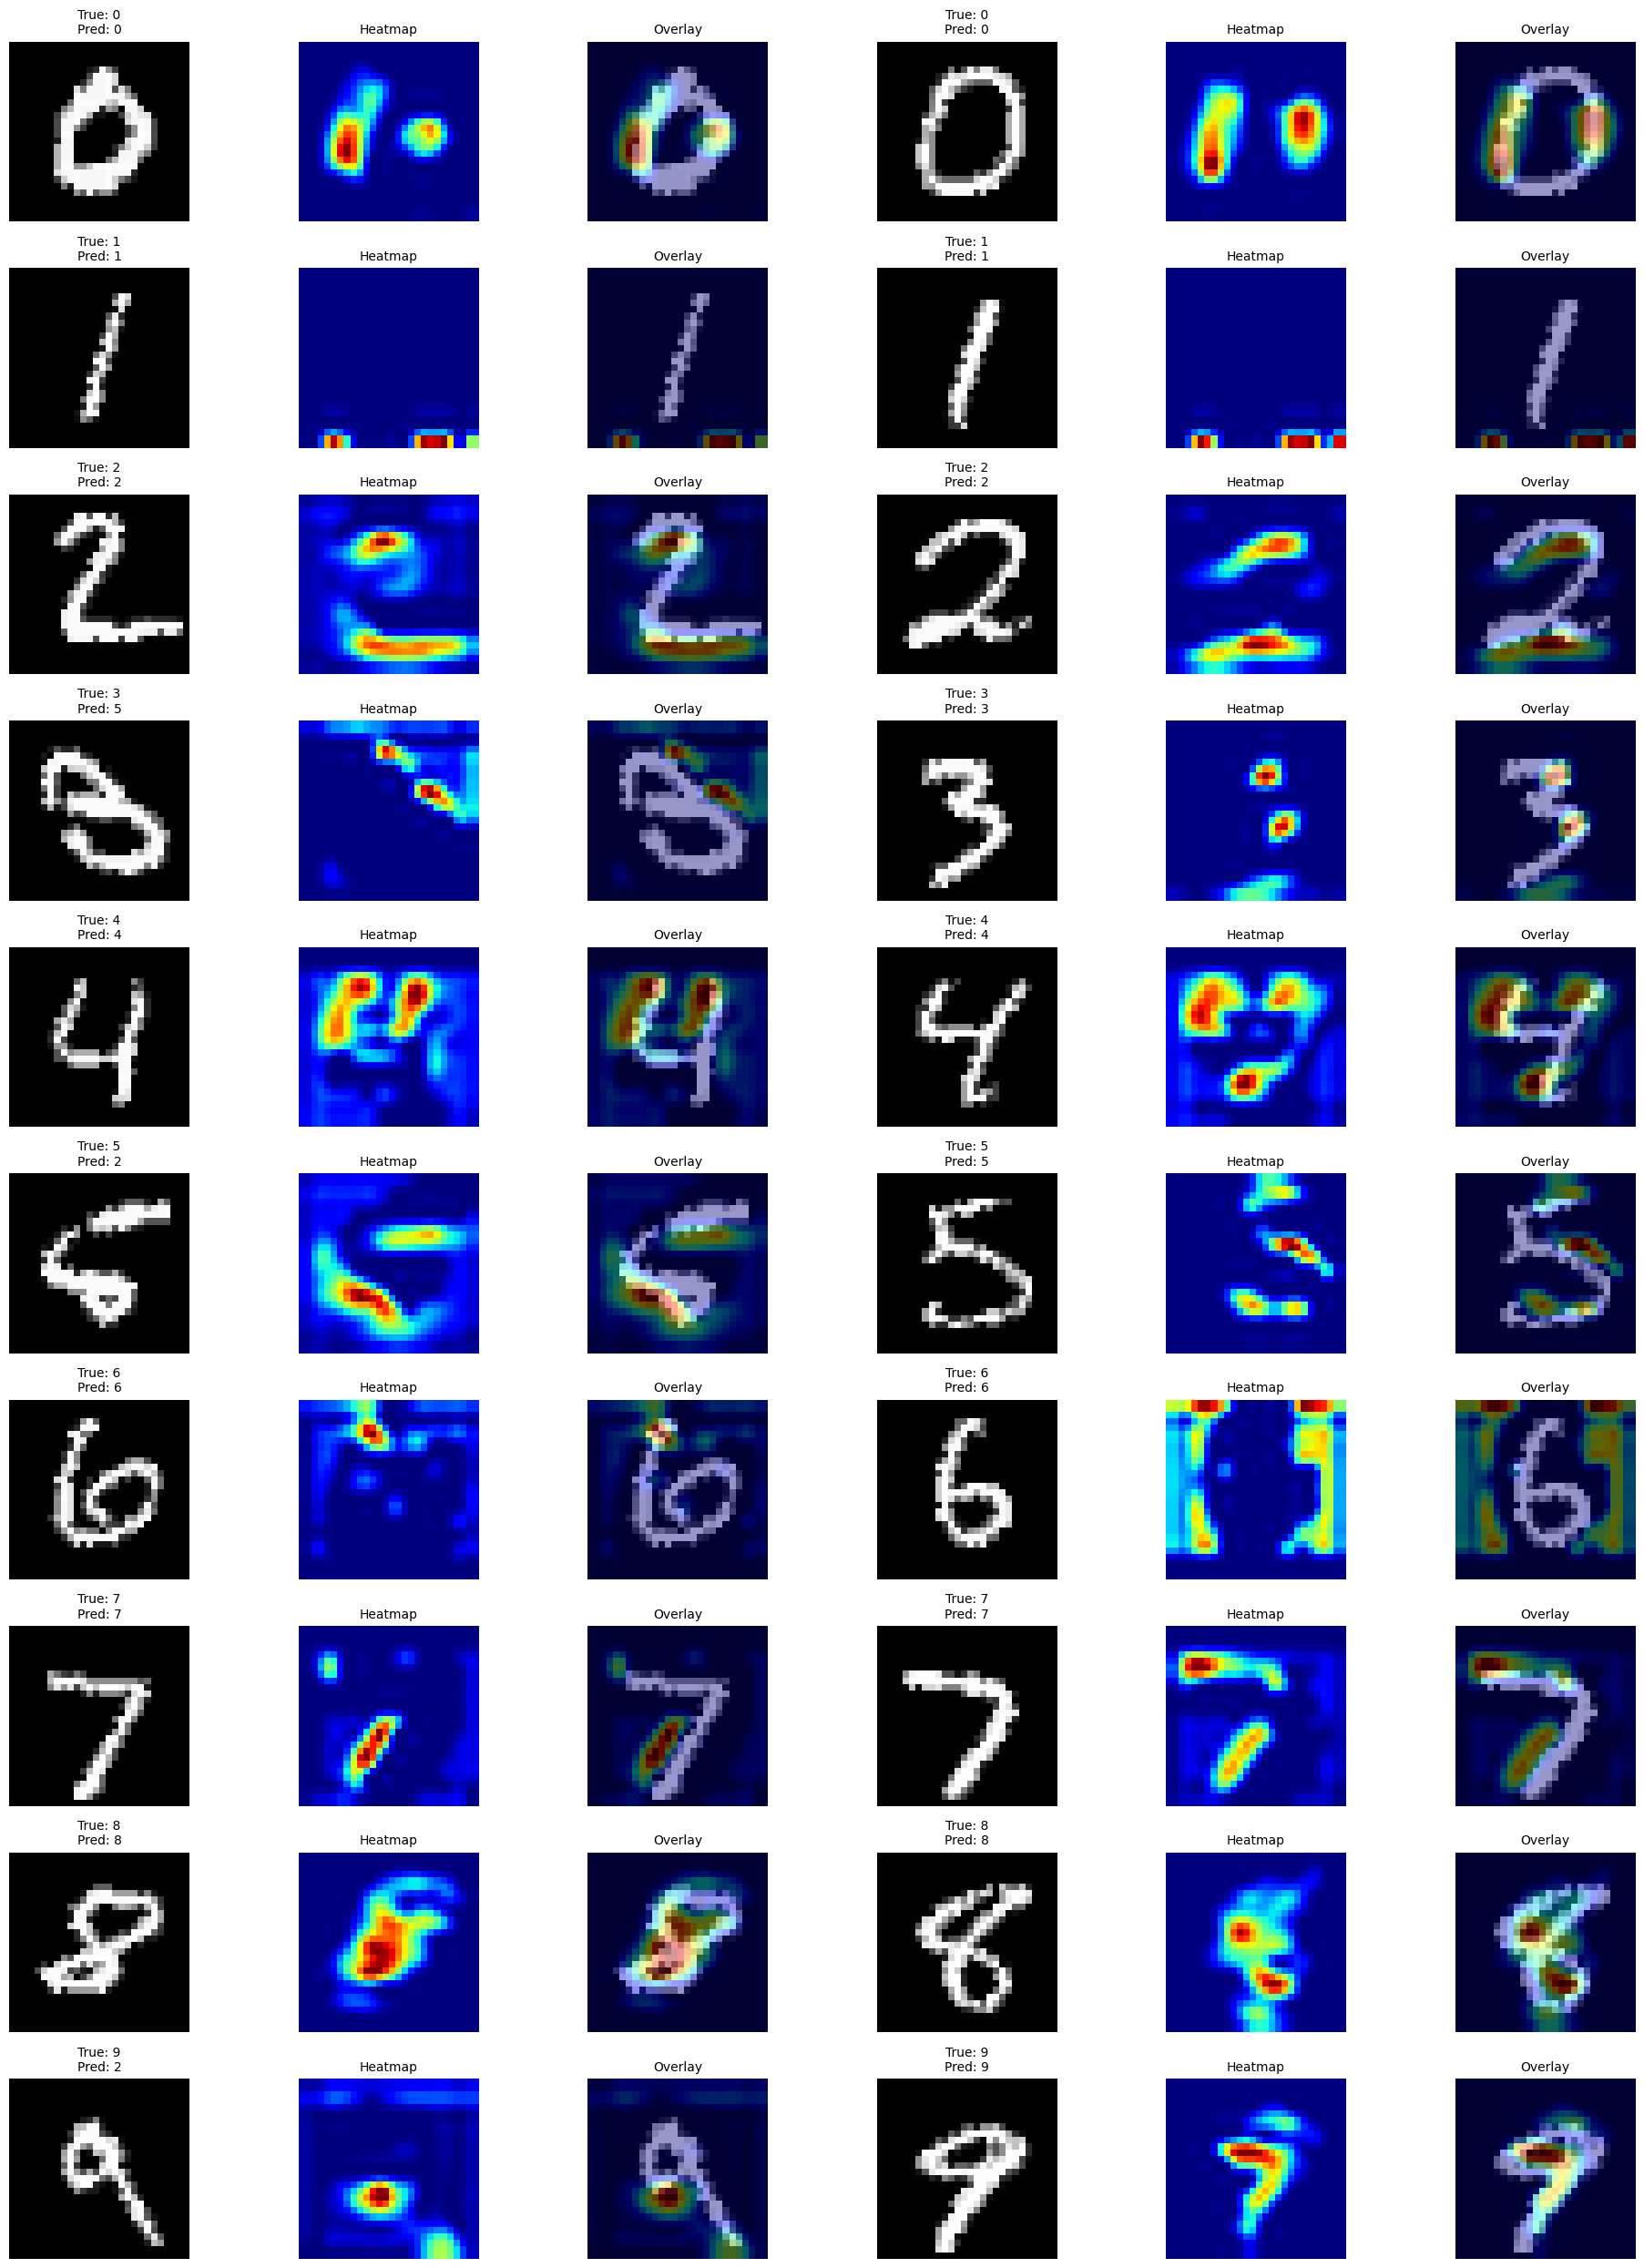

In [15]:
from skimage.transform import resize
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 25))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

for class_idx in range(10):
    for sample_idx in range(2):
        result_idx = class_idx * 2 + sample_idx
        result = all_results[result_idx]
        
        img_array = np.array(result['image'])
        rescaled_img = rescale_intensity(img_array, out_range=(0, 1))
        
        heatmap = resize(result['heatmap'], img_array.shape[:2], order=3)
        rescaled_heatmap = rescale_intensity(heatmap, out_range=(0.25, 1))
        
        row = class_idx
        col_start = sample_idx * 3 
        
        
        plt.subplot(10, 6, row * 6 + col_start + 1)
        plt.imshow(rescaled_img, cmap='gray')
        plt.title(f"True: {result['true_label']}\nPred: {result['pred_class']}", fontsize=10)
        plt.axis('off')
        
        plt.subplot(10, 6, row * 6 + col_start + 2)
        plt.imshow(rescaled_heatmap, cmap='jet')
        plt.title("Heatmap", fontsize=10)
        plt.axis('off')
        
        plt.subplot(10, 6, row * 6 + col_start + 3)
        plt.imshow(rescaled_img, cmap='gray')
        plt.imshow(rescaled_heatmap, cmap='jet', alpha=0.4)
        plt.title("Overlay", fontsize=10)
        plt.axis('off')

plt.tight_layout()
plt.show()